In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../ready_data/merged_marwis.csv", index_col="timestamp")
# Drop columns which we are not able to get via weather forecast API


In [3]:
# initialize DF for saving metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']})

In [4]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop(["Friction"], axis=1)

# have only the target variable here (dependent variable)
y = df['Friction']

In [5]:
# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

<h1>Linear Regression<h1>

In [6]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

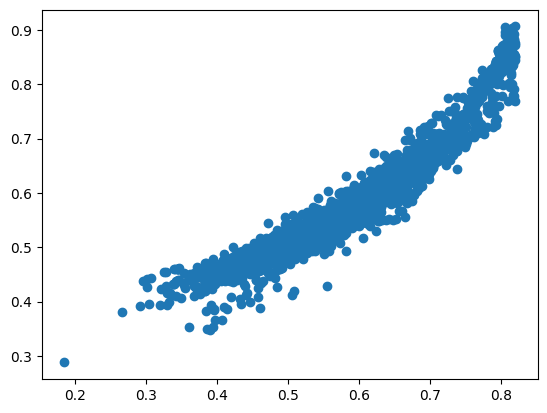

In [7]:
plt.scatter(y_test, predictions)
plt.show()

In [8]:
# MAE - Mean average error
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
# MSE - Mean square error
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
# RMSE - Root mean square error
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2)
# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["LinearReg"] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg
0,Mean Squared Error,0.00
1,Root Mean Squared Error,0.04
2,Mean Absolute Error,0.03
3,R-squared,0.92


In [9]:

xgb_model = XGBRegressor(random_state=101)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["XGB"] = [mse, rmse, mae, r2]

metrics_df

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,LinearReg,XGB
0,Mean Squared Error,0.00,0.00
1,Root Mean Squared Error,0.04,0.01
2,Mean Absolute Error,0.03,0.01
3,R-squared,0.92,0.99


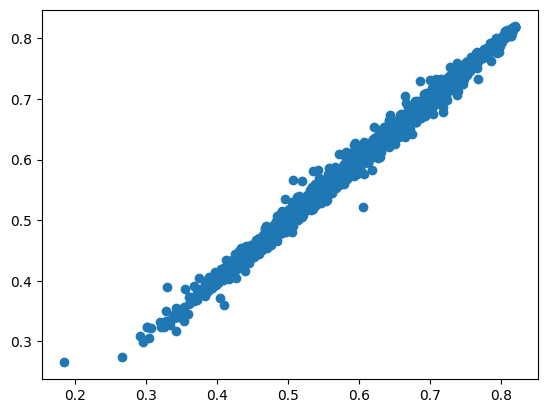

In [10]:
plt.scatter(y_test, predictions)
plt.show()

<h1>XGB and Optuna</h1>

In [11]:
# 1. Wrap model training with an objective function and return accuracy
def objective(trial):
    # Suggest values of the hyperparameters using a trial object.
    # Check model's (!!! not the optuna) documentation to find out possible parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    # Model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Wanted metric to optimize
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [12]:
# Create a study object and optimize the objective function.
# Directions: minimize and maximize; Trials are smth similar to epochs.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Save best hyperparameters into variable
best_params = study.best_params
# Final model with best parameters
final_model = XGBRegressor(**best_params, random_state=101)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)

# Add new metrics to metrics df
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df['XGB Optuna'] = [mse, rmse, mae, r2]
metrics_df

[I 2024-11-25 10:56:56,857] A new study created in memory with name: no-name-86f04466-fb6e-428e-af89-2ef0d9f3807a
/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-25 10:56:59,294] Trial 0 finished with value: 0.019116413277147856 and parameters: {'learning_rate': 0.03217662661977839, 'n_estimators': 1551, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7691648723733571, 'colsample_bytree': 0.5989961239315841, 'gamma': 0.07879738874693776, 'reg_alpha': 0.5150435498154528, 'reg_lambda': 0.3435154374253273}. Best is trial 0 with value: 0.019116413277147856.
/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in versi

,Metric,LinearReg,XGB,XGB Optuna
0,Mean Squared Error,0.00,0.00,0.00
1,Root Mean Squared Error,0.04,0.01,0.01
2,Mean Absolute Error,0.03,0.01,0.01
3,R-squared,0.92,0.99,0.99


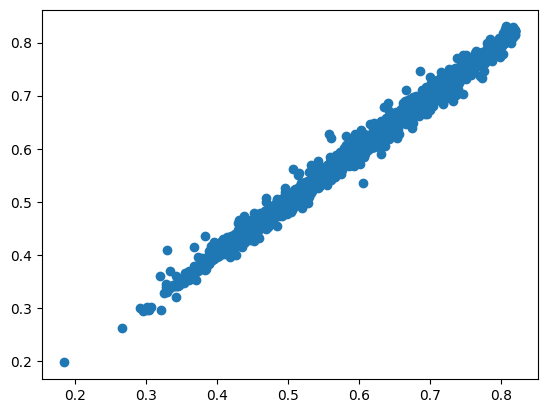

In [13]:
plt.scatter(y_test, predictions)
plt.show()

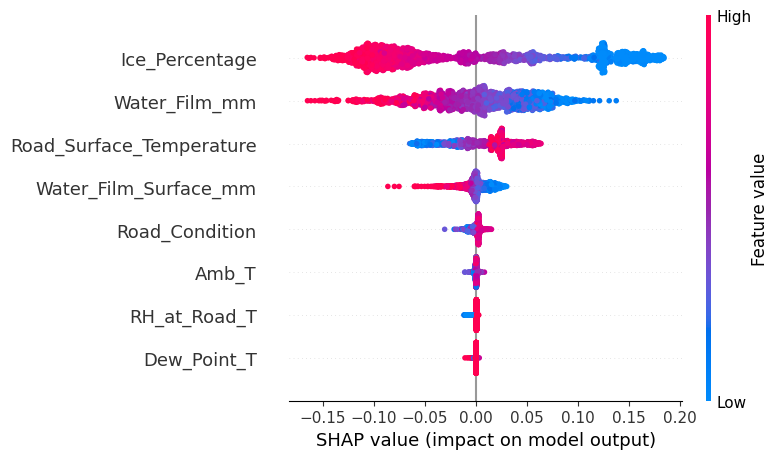

Feature Importances using SHAP:
                    Feature  Importance
0                     Amb_T    0.000727
1               Dew_Point_T    0.000100
2              RH_at_Road_T    0.000718
3             Water_Film_mm    0.041188
4            Ice_Percentage    0.087924
5            Road_Condition    0.003581
6     Water_Film_Surface_mm    0.008697
7  Road_Surface_Temperature    0.025811


In [14]:
import shap
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.mean(np.abs(shap_values), axis=0)
})
print("Feature Importances using SHAP:")
print(importance)

In [15]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

# Explain a prediction
i = 1  # Index of the sample to explain
exp = explainer.explain_instance(X_test.values[i], xgb_model.predict)
exp.show_in_notebook(show_table=True)

# Extract feature importance
importances = exp.as_list()
importance_df = pd.DataFrame(importances, columns=['Feature', 'Importance'])
print("Feature Importances using LIME:")
print(importance_df)

Feature Importances using LIME:
                           Feature  Importance
0          Ice_Percentage <= 16.18    0.180933
1            Water_Film_mm <= 0.20    0.099711
2  Road_Surface_Temperature > 1.34    0.046543
3    Water_Film_Surface_mm <= 0.07    0.025696
4           Road_Condition <= 2.00   -0.022641
5              Dew_Point_T <= 0.00    0.005813
6             1.57 < Amb_T <= 6.42   -0.002760
7   99.98 < RH_at_Road_T <= 100.00    0.001021
